# Unsteady flow around a cylinder ($Re=200$)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ibmos as ib

## Numerical grid and solver initialization

In [3]:
s1 = ib.stretching(256, 0.033, 0.20, int(0.5/0.033+16), 16, 16, 0.04)
s2 = ib.stretching(128, 0.033, 0.20, int(0.5/0.033+16), 16, 16, 0.04)
x = np.r_[-s2[::-1], s1[1:]]

s = ib.stretching(192, 0.033, 0.20, int(0.5/0.033+16), 16, 16, 0.04)
y = np.r_[-s[::-1], s[1:]]

solver = ib.Solver(x, y, iRe=1/200.0, Co=0.015/0.033)

## Immersed boundaries

In [4]:
solver.set_solids(ib.shapes.cylinder("cylinder", 0, 0, 0.5, solver.dxmin))

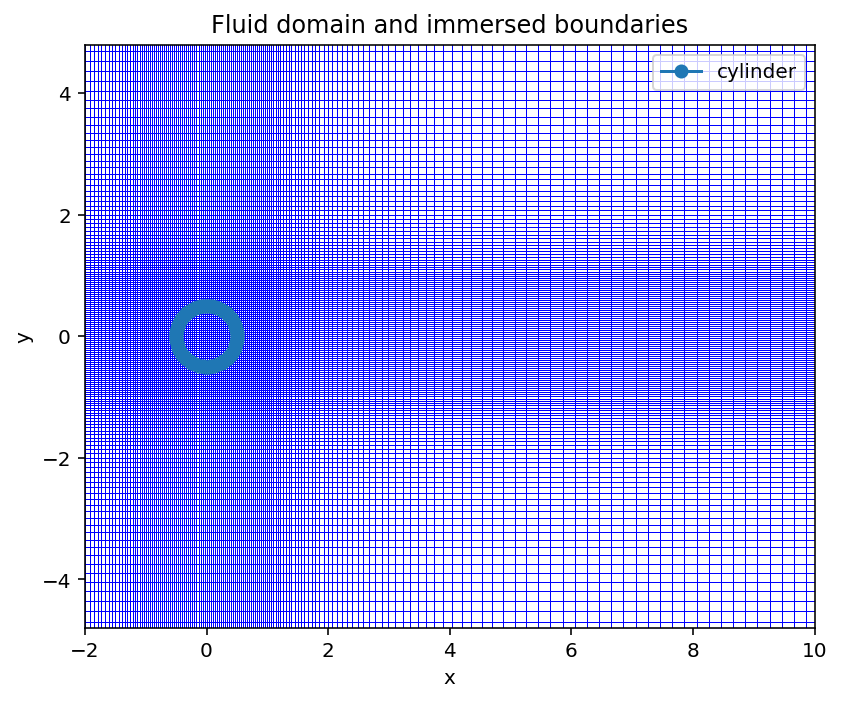

In [5]:
solver.plot_domain(figsize=(6, 5), xlim=(-2, 10), ylim=(-2, 2));

## Boundary conditions

In [6]:
fvBC = (lambda s, t: np.zeros_like(s),)*4
fuBC = (lambda s, t: np.ones_like(s),)*4
fsBC = ((lambda ξ, η, t: np.zeros_like(ξ),)*2, )

## Initial condition

In [7]:
u, v, p, *f = solver.reshape(solver.unpack(solver.zero()), 0)
c, r, ϵ = -10, 1.0, 0.01
u[:,:] = 1.0-ϵ*solver.fluid.u.y[:,np.newaxis]*np.exp(-((solver.fluid.u.x[np.newaxis,:]-c)**2 + solver.fluid.u.y[:,np.newaxis]**2)/r**2)
v[:,:] = ϵ*(solver.fluid.v.x[np.newaxis,:]-c)*np.exp(-((solver.fluid.v.x[np.newaxis,:]-c)**2 + solver.fluid.v.y[:,np.newaxis]**2)/r**2)
x0 = solver.pack(u, v, p, *f)

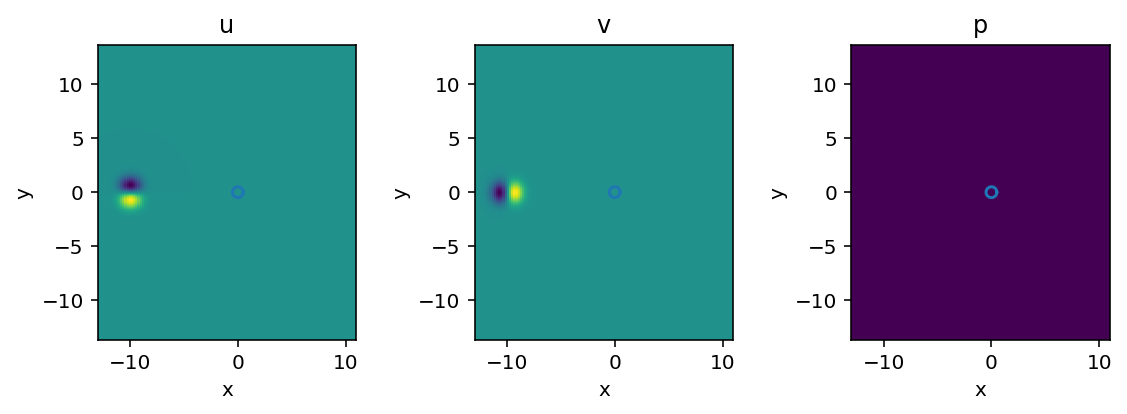

In [8]:
solver.plot_field(x0, xlim=(-12, 10), ylim=(-2, 2))

## Unsteady simulation

In [9]:
%%time 
x, t, infodict = solver.steps(x0, fuBC, fvBC, fsBC, outflowEast=True, 
                              saveEvery=5, number=int(100/solver.dt), verbose=int(1.5/solver.dt))

Initializing solver...done.
       k            t          x_2       dxdt_2  cylinder_fx  cylinder_fy  Uinf@outlet 
     100  1.50000e+00  3.82728e+02  3.17433e+01  1.37829e+00  2.53267e-07  1.00000e+00 
     200  3.00000e+00  3.82922e+02  1.33993e+01  1.24164e+00  1.33543e-06  1.00000e+00 
     300  4.50000e+00  3.82584e+02  8.50491e+00  1.14627e+00  7.56453e-06  1.00000e+00 
     400  6.00000e+00  3.82315e+02  6.33276e+00  1.08859e+00  6.84949e-05  1.00000e+00 
     500  7.50000e+00  3.82074e+02  5.12544e+00  1.04837e+00  9.83883e-04  1.00000e+00 
     600  9.00000e+00  3.81834e+02  4.31895e+00  1.01867e+00  4.99818e-03  1.00000e+00 
     700  1.05000e+01  3.81595e+02  3.74266e+00  9.96159e-01 -4.46625e-03  1.00000e+00 
     800  1.20000e+01  3.81362e+02  3.30962e+00  9.78791e-01 -3.88864e-03  1.00000e+00 
     900  1.35000e+01  3.81136e+02  2.97542e+00  9.65191e-01  3.40031e-03  1.00000e+00 
    1000  1.50000e+01  3.80918e+02  2.71065e+00  9.54421e-01  4.24729e-03  1.00000e+00 
    

## Display results

Display velocity field and pressure at the last time step

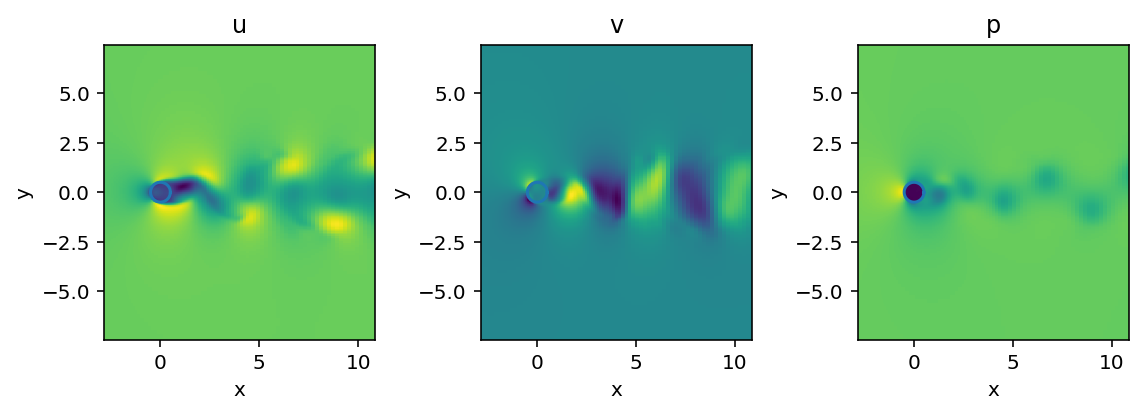

In [10]:
solver.plot_field(x[-1], equal=True, xlim=(-2, 10), ylim=(-2, 2));

Temporal evolution of the force coefficients

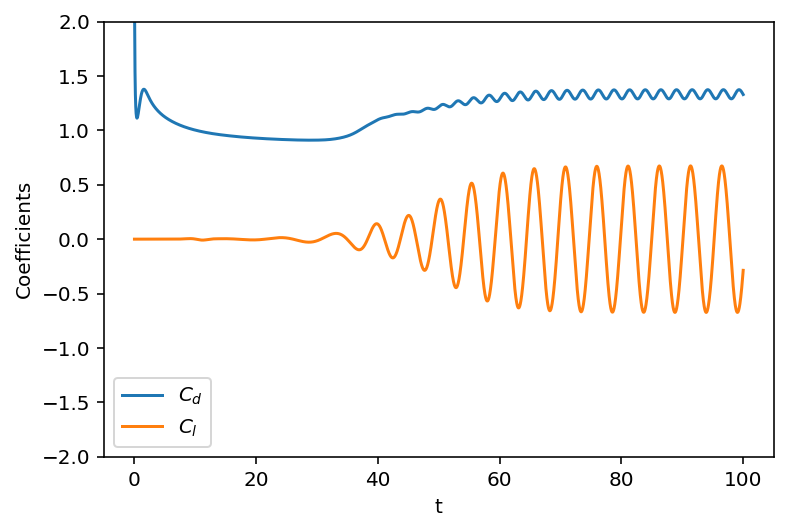

In [11]:
plt.plot(infodict['t'], infodict['cylinder_fx'], label=r'$C_d$')
plt.plot(infodict['t'], infodict['cylinder_fy'], label=r'$C_l$')
plt.ylim(-2, 2)
plt.xlabel('t')
plt.ylabel('Coefficients')
plt.legend();

Animation

In [12]:
from IPython.display import HTML
from matplotlib import animation
%config InlineBackend.figure_format = 'png'

<Figure size 432x288 with 0 Axes>

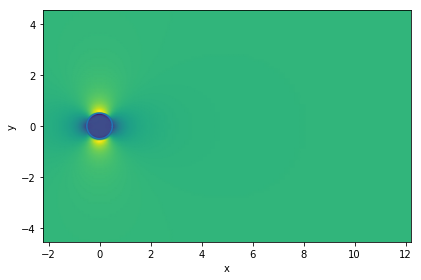

In [13]:
plt.figure()
fig, ax = plt.subplots()
quad = ax.pcolormesh(solver.fluid.u.x, solver.fluid.u.y,
                     solver.reshape(solver.unpack(x[0]), 0)[0],
                     rasterized=True, shading='gouraud')

for solid in solver.solids:
    plt.plot(solid.ξ, solid.η)
    
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-2, 12)
ax.set_ylim(-2, 2)
fig.tight_layout()

In [14]:
def init():
    quad.set_array([])
    return quad,

def animate(i):
    quad.set_array(solver.unpack(x[i])[0].ravel())
    return quad,

anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=len(x), interval=15, blit=True)

In [15]:
%time HTML(anim.to_html5_video())

CPU times: user 1h 5min 12s, sys: 1min 48s, total: 1h 7min 1s
Wall time: 8min 18s
